In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import itertools
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction import text
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

from nltk.corpus import stopwords

%matplotlib inline

pd.set_option('display.max_columns', 100)

# Dataset and parsing/cleaning of data

In [2]:
data = pd.read_csv('mycareersfuture_master.csv')

In [ ]:
data.head()

In [3]:
# Parse the salary columns

# Remove dollar sign and comma
for col in ['SalaryLower', 'SalaryUpper']:
    data[col] = [re.sub('[$,]', '', text) for text in data[col]]
    
# Extracting the text and placing into a new column 'SalaryType
data['SalaryType'] = data['SalaryUpper'].apply(lambda x: re.search('\D+', x).group())

# Extracting only the numerical value for the SalaryUpper column
data['SalaryUpper'] = data['SalaryUpper'].apply(lambda x: re.match('\d*', x).group())

# Replacing the text 'Salary undisclosed' with NaN
data[['SalaryLower', 'SalaryType']] = data[['SalaryLower', 'SalaryType']].replace('Salary undisclosed', np.nan)

# Replacing '' in SalaryUpper with NaN
data['SalaryUpper'] = data['SalaryUpper'].replace('', np.nan)

# Set the salary columns to numeric
data[['SalaryLower', 'SalaryUpper']] = data[['SalaryLower', 'SalaryUpper']].astype('float32')

# Convert the annual salary data into monthly salary data
data.loc[data['SalaryType']=='Annually', ['SalaryLower', 'SalaryUpper']] = \
data[data['SalaryType']=='Annually'][['SalaryLower', 'SalaryUpper']].apply(lambda x: x/12)

# Update the SalaryType to monthly
data.loc[data['SalaryType']=='Annually', 'SalaryType'] = 'Monthly'

# Create SalaryMean which is the mean of SalaryLower and SalaryUpper
data['SalaryMean'] = (data['SalaryLower'] + data['SalaryUpper']) / 2.

In [4]:
data['EmploymentType'].value_counts()

# Exclude all those job listings that are temporary, freelance, internship

Full Time                                                            252
Contract, Full Time                                                  151
Permanent, Full Time                                                 125
Permanent                                                            125
Contract                                                              78
Permanent, Contract                                                   12
Permanent, Contract, Full Time                                         8
Temporary                                                              4
Freelance                                                              4
Internship                                                             3
Part Time, Contract, Flexi work                                        2
Freelance, Flexi work                                                  2
Part Time, Contract                                                    1
Part Time, Permanent, Temporary, Contract, Flexi wo

In [5]:
# Create a list of those Employment Types to drop
emp_type_list = data['EmploymentType'].value_counts().index[7::]

# Iterate through each Employment Type and exclude them
for emp_type in emp_type_list:
    data = data[data['EmploymentType'] != emp_type].copy()

In [6]:
# Combine RoleDesc and Requirements
data['JD'] = data['RoleDesc'] + ' ' + data['Requirements']

In [7]:
# Parse dummy variables for columns, JobCategories, EmploymentType, Seniority
col_list = ['JobCategories', 'EmploymentType', 'Seniority']

for col in col_list:
    value_list = data[col].unique()
    value_list = [value.split(',') for value in value_list]
    value_list = list(itertools.chain(*value_list))
    value_list = [str.strip(value) for value in value_list]
    value_list = np.unique(value_list)
    
    # Create dummy variables for the column
    for value in value_list:
        data.loc[data[col].str.contains(value), value] = 1
        
    # Replace NaN with zero
    data[value_list] = data[value_list].fillna(value=0)
    

## Question 1

In [18]:
iqr = np.percentile(data[~data['SalaryMean'].isnull()]['SalaryMean'], 75) - \
np.percentile(data[~data['SalaryMean'].isnull()]['SalaryMean'], 25)
sal_median = np.percentile(data[~data['SalaryMean'].isnull()]['SalaryMean'], 50)
print iqr, sal_median

3125.0 6500.0


In [21]:
data2 = data[(~data['SalaryMean'].isnull()) & (data['SalaryMean']<=(1.5*iqr+sal_median))].copy()

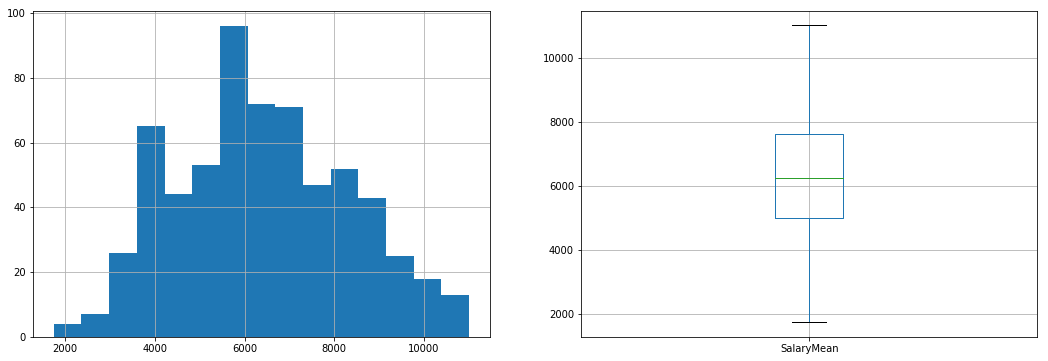

In [22]:
# Look at the distribution of SalaryMean
fig = plt.figure(figsize=(18,6))
ax1 = fig.add_subplot(121)
data2['SalaryMean'].hist(ax=ax1, bins=15)
ax2 = fig.add_subplot(122)
data2.boxplot(column='SalaryMean', ax=ax2)

In [23]:
data2['SalaryLabel'] = data2['SalaryMean'].apply(lambda x: 1 if x > data2['SalaryMean'].median() else 0)

In [24]:
x3 = data2['JD'].copy()
y3 = data2['SalaryLabel'].copy()

In [25]:
x3_train, x3_test, y3_train, y3_test = train_test_split(x3, y3, test_size=0.3, random_state=29)

In [26]:
cvt3 = CountVectorizer(ngram_range=(1,4))
tokens3_train = pd.DataFrame(cvt3.fit_transform(x3_train).todense(), columns=cvt3.get_feature_names())

# Tokenise the x_test using the same trained CountVectorizer
tokens3_test = pd.DataFrame(cvt3.transform(x3_test).todense(), columns=cvt3.get_feature_names())

lr3 = LogisticRegression(random_state=29)
lr3.fit(tokens3_train, y3_train)
print(classification_report(y3_test, lr3.predict(tokens3_test), labels=[0,1], target_names=['Below Median', 'Above Median']))

              precision    recall  f1-score   support

Below Median       0.61      0.70      0.66        88
Above Median       0.71      0.62      0.66       103

 avg / total       0.67      0.66      0.66       191



In [ ]:
# Look at the distribution of SalaryMean
fig = plt.figure(figsize=(18,6))
ax1 = fig.add_subplot(121)
data['SalaryMean'].hist(ax=ax1, bins=15)
ax2 = fig.add_subplot(122)
data.boxplot(column='SalaryMean', ax=ax2)

In [ ]:
data1 = data[~data['SalaryMean'].isnull()].copy()

In [ ]:
# As the distribution of salary is right skewed with a long right tail,
# classify the salary into 2 groups - Above Median (1) and Median and Below (0) 

data1['SalaryLabel'] = data1['SalaryMean'].apply(lambda x: 1 if x > data1['SalaryMean'].median() else 0)

In [ ]:
# check correlation of dummy variables with target

sector_var = pd.concat([data1.iloc[:,15:47].copy(), data1['SalaryLabel']], axis=1)
emptype_var = pd.concat([data1.iloc[:,47:50].copy(), data1['SalaryLabel']], axis=1)
senior_var = pd.concat([data1.iloc[:,50::].copy(), data1['SalaryLabel']], axis=1)

In [ ]:
fig = plt.figure(figsize=(10,6))
sns.heatmap(senior_var.corr(), annot=True)

# the seniority features have little correlation with the target variable SalaryLabel

In [ ]:
fig = plt.figure(figsize=(10,6))
sns.heatmap(emptype_var.corr(), annot=True)

# the EmploymentType features have little correlation with the target variable SalaryLabel

In [ ]:
sector_corr = sector_var.corr()
print sector_corr.iloc[:, -1]

# the sector features have little correlation with the target variable SalaryLabel

Hence for the prediction of classification labels of salary, use only the job description  
and job requirements and discard the other features

### Set up predictor and target varibles plus split data for train and test

In [ ]:
# copy JD column to as x variable, SalaryLabel as y

x = data1['JD'].copy()
y = data1['SalaryLabel'].copy()

In [ ]:
# baseline accuracy
print(1. - y.mean())

In [ ]:
# Train test split the data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=29)


## Try first model of LogisticRegression to predict if the salary of a job posting will be above median or below median  
Start with Logistic Regression as it is a simple classification model

In [ ]:
# First model of Logistic Regression

# Tokenise the x_train which is job description and job requirements
cvt = CountVectorizer(ngram_range=(1,4))
tokens_train = pd.DataFrame(cvt.fit_transform(x_train).todense(), columns=cvt.get_feature_names())

# Tokenise the x_test using the same trained CountVectorizer
tokens_test = pd.DataFrame(cvt.transform(x_test).todense(), columns=cvt.get_feature_names())

lr = LogisticRegression(random_state=29)
lr.fit(tokens_train, y_train)

In [ ]:
tokens_train.shape

In [ ]:
# Cross-validate the Logistic Regression model
scores = cross_val_score(lr, tokens_train, y_train, cv=5, n_jobs=-1, verbose=1)
print('Cross validation score: {}'.format(scores))
print('Mean score: {}'.format(np.mean(scores)))

# Score on test data
print('Score on test data: {}'.format(lr.score(tokens_test, y_test)))

In [ ]:
# Extract the coefficients of the Logistic Regression against the tokens
lr_coef = pd.DataFrame({'tokens':tokens_train.columns, 'lr_coef':lr.coef_[0]})

In [ ]:
# Sort the tokens by descending order of the regression coefficients
lr_coef = lr_coef.sort_values(by='lr_coef', axis=0, ascending=False)

# Identify the top 20 features which are most important to predict the classification of salary above median
lr_coef.head(20)

In [ ]:
print(classification_report(y_test, lr.predict(tokens_test), labels=[0,1], target_names=['Below Median', 'Above Median']))

# The model performs better at predicting below median salaries than above median.  This is probably due to the wide variance
# in salaries above median.  From the box plot above we saw that there are many salary outliers above the median.

In [ ]:
# Tuning of LogisticRegression model for better results
params = {
    'C' : [0.2, 0.6, 1.0],
    'solver' : ['newton-cg', 'lbfgs', 'sag']
}

lr_gs = GridSearchCV(lr, param_grid=params, cv=3, n_jobs=-1, verbose=1)
lr_gs.fit(tokens_train, y_train)

In [ ]:
print(lr_gs.best_params_)
print(lr_gs.best_score_)

In [ ]:
# Score test data with tuned parameters 
lr = LogisticRegression(C=0.6, solver='newton-cg', random_state=29)
lr.fit(tokens_train, y_train)

print('Score on test data: {}'.format(lr.score(tokens_test, y_test)))

# Accuracy is only improved marginally

In [ ]:
# Second model of RandomForest
rfc = RandomForestClassifier(n_jobs=-1, random_state=29, verbose=1)
rfc.fit(tokens_train, y_train)


In [ ]:
# Cross-validate the RandomForest model
scores = cross_val_score(rfc, tokens_train, y_train, cv=5, n_jobs=-1)
print('Cross validation score: {}'.format(scores))
print('Mean score: {}'.format(np.mean(scores)))

# Score on test data
print('Score on test data: {}'.format(rfc.score(tokens_test, y_test)))


In [ ]:
print(classification_report(y_test, rfc.predict(tokens_test), labels=[0,1], target_names=['Below Median', 'Above Median']))

# The random forest classifier performs even worse than Logistic Regression in predicting above median salaries. Probably
# some pruning of the decision trees is required to improve the performance.

In [ ]:
# Tuning of RandomForest model for better results
params = {
    'n_estimators' : range(1, 11, 2),
    'criterion' : ['gini', 'entropy'],
    'max_depth' : [1, 2, 3, None]
}

rf_gs = GridSearchCV(rfc, param_grid=params, cv=3, n_jobs=-1, verbose=1)
rf_gs.fit(tokens_train, y_train)

In [ ]:
print(rf_gs.best_params_)
print(rf_gs.best_score_)

In [ ]:
# Score test data with tuned parameters 
rfc = RandomForestClassifier(n_estimators=3, criterion='entropy', max_depth=None, n_jobs=-1, random_state=29, verbose=1)
rfc.fit(tokens_train, y_train)

print('Score on test data: {}'.format(rfc.score(tokens_test, y_test)))

# Accuracy improved slightly to be almost the same as Logistic Regression

## Question 2
Set up the target variable as IT sector versus non-IT sector jobs and build a classification model  
to predict it

In [ ]:
# Set up y variable to the binary column "Information Technology"
x2 = data['JD'].copy()
y2 = data['Information Technology'].copy()

In [ ]:
# Split the data into train and test
x2_train, x2_test, y2_train, y2_test = train_test_split(x2, y2, test_size=0.3, random_state=29)

In [ ]:
# Tokenise the x2_train
cvt2 = CountVectorizer(ngram_range=(1,4))
tokens2_train = pd.DataFrame(cvt2.fit_transform(x2_train).todense(), columns=cvt2.get_feature_names())

# Tokenise the x2_test using the same trained CountVectorizer
tokens2_test = pd.DataFrame(cvt2.transform(x2_test).todense(), columns=cvt2.get_feature_names())

lr2 = LogisticRegression(random_state=29)
lr2.fit(tokens2_train, y2_train)

In [ ]:
# Cross-validate the Logistic Regression model
scores = cross_val_score(lr2, tokens2_train, y2_train, cv=5, n_jobs=-1, verbose=1)
print('Cross validation score: {}'.format(scores))
print('Mean score: {}'.format(np.mean(scores)))

# Score on test data
print('Score on test data: {}'.format(lr2.score(tokens2_test, y2_test)))

In [ ]:
print(classification_report(y2_test, lr2.predict(tokens2_test), labels=[0,1], target_names=['Non-IT sector', 'IT sector']))


In [ ]:
# Try RandomForestClassifier to compare the performance

rfc2 = RandomForestClassifier(n_jobs=-1, random_state=29, verbose=1)
rfc2.fit(tokens2_train, y2_train)

In [ ]:
# Cross-validate the RandomForest model
scores = cross_val_score(rfc2, tokens2_train, y2_train, cv=5, n_jobs=-1)
print('Cross validation score: {}'.format(scores))
print('Mean score: {}'.format(np.mean(scores)))

# Score on test data
print('Score on test data: {}'.format(rfc2.score(tokens2_test, y2_test)))


In [ ]:
print(classification_report(y2_test, rfc2.predict(tokens2_test), labels=[0,1], target_names=['Non-IT sector', 'IT sector']))
